In [ ]:
!pip install tensorflow matplotlib numpy

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

DATASET_DIR = "/content/drive/MyDrive/DATASET (1)/train"

IMG_SHAPE = IMG_SIZE + (3,)


In [ ]:
train_dataset_raw = image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.1,
    subset="training",
    seed=SEED
)

validation_dataset_raw = image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.1,
    subset="validation",
    seed=SEED
)


Found 1248 files belonging to 3 classes.
Using 1124 files for training.
Found 1248 files belonging to 3 classes.
Using 124 files for validation.


In [ ]:
class_names = train_dataset_raw.class_names
num_classes = len(class_names)

print("Detected classes:", class_names)
print("num_classes =", num_classes)


Detected classes: ['Aedes aegypti', 'Aedes albopictus', 'Culex quinquefasciatus']
num_classes = 3


In [ ]:
train_dataset = train_dataset_raw
validation_dataset = validation_dataset_raw


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])


In [ ]:
def build_model(num_classes):

    base_model = tf.keras.applications.VGG16(
        input_shape=IMG_SHAPE,
        include_top=False,
        weights="imagenet"
    )

    for layer in base_model.layers[:-3]:
        layer.trainable = False

    inputs = tf.keras.Input(shape=IMG_SHAPE)

    x = data_augmentation(inputs)
    x = tf.keras.applications.vgg16.preprocess_input(x)

    x = base_model(x, training=True)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [ ]:
model = build_model(num_classes)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        771 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,846,787 (56.64 MB)

 Trainable params: 4,851,715 (18.51 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/vgg16_best.keras"

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[checkpoint],
    verbose=1
)


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4602 - loss: 1.7319 
Epoch 1: val_accuracy improved from -inf to 0.79839, saving model to /content/drive/MyDrive/vgg16_best.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 978s 27s/step - accuracy: 0.4627 - loss: 1.7161 - val_accuracy: 0.7984 - val_loss: 0.4662
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.7526 - loss: 0.6145 
Epoch 2: val_accuracy improved from 0.79839 to 0.89516, saving model to /content/drive/MyDrive/vgg16_best.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 887s 25s/step - accuracy: 0.7535 - loss: 0.6119 - val_accuracy: 0.8952 - val_loss: 0.2376
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.8389 - loss: 0.3806 
Epoch 3: val_accuracy improved from 0.89516 to 0.90323, saving model to /content/drive/MyDrive/vgg16_best.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 916s 24s/step - accuracy: 0.8393 - loss: 0.3796 - val_accuracy: 0.9032 - val_loss: 0.2007
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy:

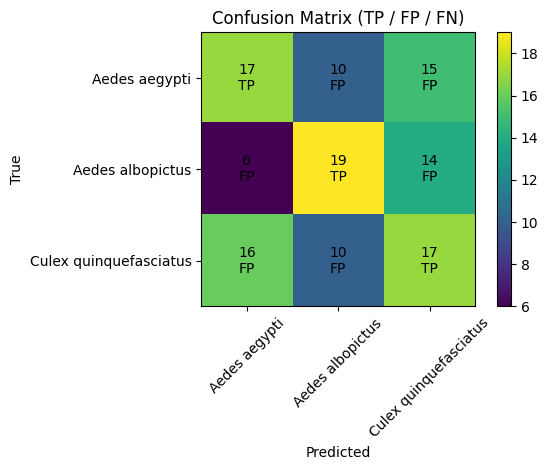

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

class_names = validation_dataset.class_names

cm = confusion_matrix(y_true, y_pred)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (TP / FP / FN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()

plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)

# Correct per-cell labeling
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]

        if i == j:
            label = "TP"
        else:
            label = "FP" if cm[:, j].sum() - cm[j, j] > 0 else "FN"

        plt.text(j, i, f"{value}\n{label}", ha="center", va="center")

plt.tight_layout()
plt.show()


In [43]:
for i, name in enumerate(class_names):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    print(f"\n{name}")
    print("TP:", TP)
    print("FP:", FP)
    print("FN:", FN)
    print("TN:", TN)



Aedes aegypti
TP: 17
FP: 22
FN: 25
TN: 60

Aedes albopictus
TP: 19
FP: 20
FN: 20
TN: 65

Culex quinquefasciatus
TP: 17
FP: 29
FN: 26
TN: 52


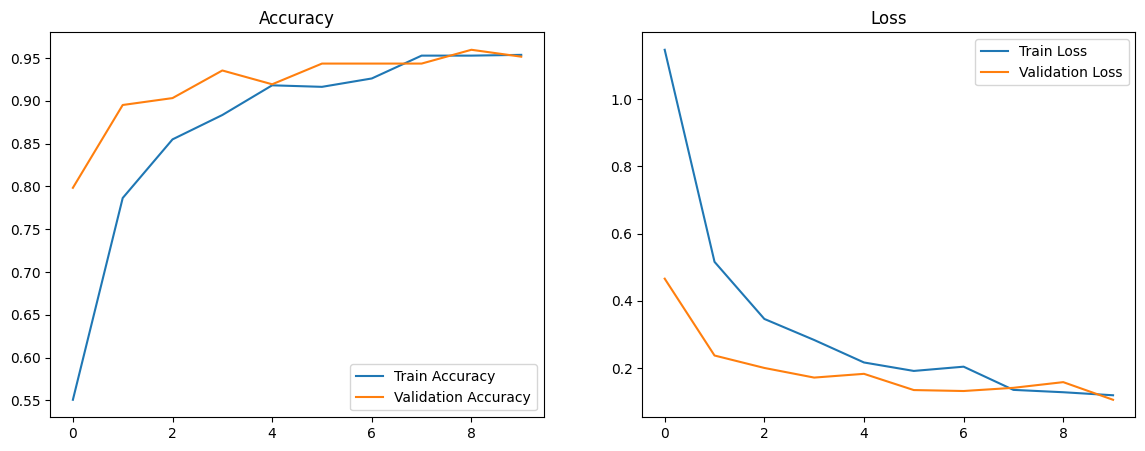

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.show()


In [ ]:
best_model = tf.keras.models.load_model(checkpoint_path)

In [ ]:
TEST_DIR = "/content/drive/MyDrive/DATASET (1)/test"

test_dataset = image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",    # so it matches your model
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False                # important for evaluation
)


Found 312 files belonging to 3 classes.


In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)


10/10 ━━━━━━━━━━━━━━━━━━━━ 221s 19s/step - accuracy: 0.9465 - loss: 0.1132
Test Accuracy: 0.9551281929016113
Test Loss: 0.10015560686588287


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# -----------------------------
# 1. Get predictions
# -----------------------------
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = best_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# -----------------------------
# 2. Compute metrics
# -----------------------------
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
Precision: 0.9592
Recall:    0.9551
F1-Score:  0.9557


In [ ]:
from tensorflow.keras.preprocessing import image

def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

    preds = model.predict(img_array)
    class_index = np.argmax(preds)
    class_name = class_names[class_index]
    confidence = np.max(preds)

    return class_name, confidence
